### DATA IMPORT 

In [2]:
import numpy as np
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn.metrics import roc_curve, auc
import cv2
from PIL import Image
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from skimage.transform import resize
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Reshape, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

In [1]:
!pip install keras-tuner

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X = np.load('/Users/Odogwu/Desktop/kv7006_Assignment/Dataset/X.npy') # importing images as a numpy array
Y = np.load('/Users/Odogwu/Desktop/kv7006_Assignment/Dataset/Y.npy') # importing labels associated to images (0 = no IDC, 1 = IDC)

In [6]:
#X = np.load('/content/drive/MyDrive/X.npy') # importing images as a numpy array
#Y = np.load('/content/drive/MyDrive/Y.npy') # importing labels associated to images (0 = no IDC, 1 = IDC)

In [4]:
X.shape #verifying the shape of the image data

(5547, 50, 50, 3)

In [5]:
Y.shape #verifying the shape of the label

(5547,)

In [6]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a))) # prints the total number of images
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))# prints the total number of negative IDC
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))# prints the total number of positive IDC
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))# prints the percentage number of positive IDC
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape)) #prints the shape as regards width, height and channels
describeData(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


#### Visualizing the image classes

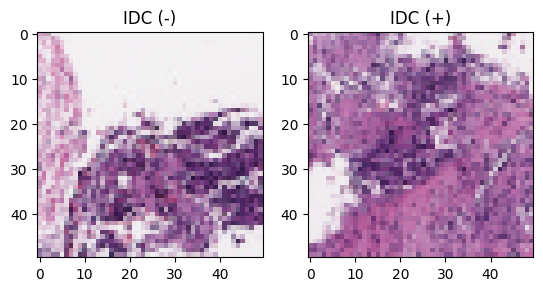

In [ ]:
#Ploting the Images
negative = X[Y==0] # (0 = no IDC, 1 = IDC)
positive = X[Y==1] 

def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
plotOne(negative, positive) 

##### HISTOGRAM PLOT:
It is frequently helpful to display the pixel intensities while working with image data in deep learning to better understand the patterns present in the data. In order to choose the best normalizing methods or spot any problems with the data, a plot of pixel intensities can provide information about the distribution of colours or grayscale values in the image.


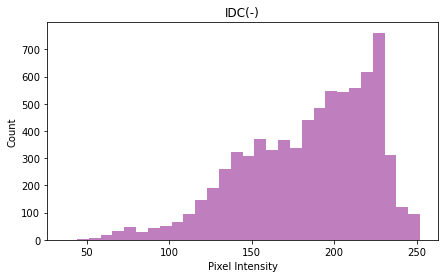

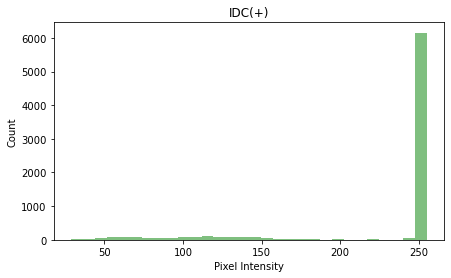

In [7]:
def plotHistogram(data, label, color):
    """
    Plot histogram of RGB Pixel Intensities for a single class
    """
    plt.figure(figsize=(7, 4))
    plt.hist(data.flatten(), bins=30, color=color, alpha=0.5)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Count')
    plt.title(label)

# obtaining samples for every class
negative_samples = X[Y == 0]
positive_samples = X[Y == 1]

# Choosing a sample image from each class
negative_image = negative_samples[0]
positive_image = positive_samples[0]

# Using purple colour to plot the histogram for the negative class 
plotHistogram(negative_image, 'IDC(-)', 'purple')
plt.show()

# Using green colour to plot the histogram for the negative class 
plotHistogram(positive_image, 'IDC(+)', 'green')
plt.show()

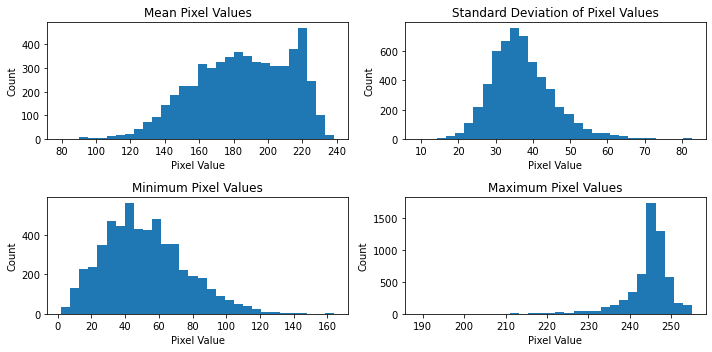

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Computting statistical measures
mean_values = np.mean(X, axis=(1, 2, 3))# getting the mean values
std_values = np.std(X, axis=(1, 2, 3)) # getting the standard deviation
min_values = np.min(X, axis=(1, 2, 3)) # getting the minimum pixel values
max_values = np.max(X, axis=(1, 2, 3)) # getting the miximum pixel values

# Plot histograms
plt.figure(figsize=(10, 5)) #setting figure size
plt.subplot(2, 2, 1) #Creating the first subplot
plt.hist(mean_values, bins=30)#plotting the mean values
plt.title('Mean Pixel Values')#plot tittle
plt.xlabel('Pixel Value')#x axis title
plt.ylabel('Count')# y axis title

plt.subplot(2, 2, 2)#Creating the second subplot
plt.hist(std_values, bins=30)#plotting the standard deviation values
plt.title('Standard Deviation of Pixel Values')#plot title
plt.xlabel('Pixel Value')# x axis label 
plt.ylabel('Count')# y axis label

plt.subplot(2, 2, 3)# creating the 3rd plot
plt.hist(min_values, bins=30)# plotting the minimum values
plt.title('Minimum Pixel Values')# plot title
plt.xlabel('Pixel Value')# xlabel
plt.ylabel('Count')# y label

plt.subplot(2, 2, 4)# 4th plot
plt.hist(max_values, bins=30)#plotting the maximum value
plt.title('Maximum Pixel Values')# plot title
plt.xlabel('Pixel Value')#x label
plt.ylabel('Count')# y label

plt.tight_layout()# Adjusting the spacing between subplots
plt.show()


### DATA PREPROCESSING

#### Image resizing to be sure all images in the X.npy folder maintains one size

In [7]:
# Defining the target size
target_size = (50, 50)

# the creating of a new array to hold the scaled images
resized_images = np.zeros((X.shape[0], target_size[0], target_size[1], X.shape[3]))

# Iterating over each image
for i in range(X.shape[0]):
    # Convert the image from NumPy array to PIL Image
    image = Image.fromarray(X[i])

    # Resizing the image
    resized_image = image.resize(target_size)

    # Converting the resized image back to NumPy array
    resized_images[i] = np.array(resized_image)

# Updating 'X' with the resized images
X = resized_images


### checking for outliers

In [8]:
import numpy as np

# Calculating the first quartile (Q1)
q1 = np.percentile(X, 25, axis=0)

# Calculating the third quartile (Q3)
q3 = np.percentile(X, 75, axis=0)

# Calculating the interquartile range (IQR)
iqr = q3 - q1

# Defining the outlier range ( 1.5 times the IQR)
outlier_range = 1.5 * iqr

# Finding outliers i.e values beyond the outlier range
outliers = np.where((X < q1 - outlier_range) | (X > q3 + outlier_range))

# Printing the indices of outlier images
print("Indices of outlier images:")
for index in outliers:
    print(index)


Indices of outlier images:
[   0    0    0 ... 5546 5546 5546]
[32 33 36 ... 45 47 48]
[36 31 33 ... 30  9  9]
[0 0 0 ... 0 0 0]


In [9]:
# Finding the number of distinct outliers
unique_outliers = np.unique(outliers)

# obtaining the count of distinct outliers
num_outliers = len(unique_outliers)

print("Number of outliers:", num_outliers)


Number of outliers: 4094


#### Dealing with the outliers found

In [10]:
# obtaining the mean of non-outlier data points
mean_value = np.mean(X)

# Replacing outlier values with the mean to retain image size due to the large number of outliers

X_without_outliers = X.copy()#preserving the original dataset while modifying the ouliers
X_without_outliers[outliers] = mean_value# replacing outliers with the mean of the data distribution
X = X_without_outliers #Retaining the dataset name

#### Verifying all outlier removal

In [11]:
# Checking if there are still any outliers in 'X'
outliers_present = np.any((X < q1 - outlier_range) | (X > q3 + outlier_range))

if outliers_present:
    print("Outliers are still present in the dataset.")
else:
    print("All outliers have been removed from the dataset.")


All outliers have been removed from the dataset.


#### Splitting the data into Train and Test set

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)# 80% training, 20% testing

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(4437, 50, 50, 3)
(4437,)
(1110, 50, 50, 3)
(1110,)


### INITIALIZING MIN-MAX AND STANDARD SCALER

#### 1. Min-max scaler

In [13]:
# normalize inputs from [0.0, 255.0] to end up with input in the range [0.0, 1.0]
X_train = np.array(X_train).astype('float32') #converting training pixel values from integers to float
X_test = np.array(X_test).astype('float32') #converting training pixel values from integers to float
X_train /= 255.0 # Dividing train data by the standard pixel intensity value
X_test /=255.0 #Dividing test data by the standard pixel intensity value

X_train.shape

(4437, 50, 50, 3)

#### 2. Standard scaler

In [14]:
# Reshaping the train data to 2D for scaling
X_train_2d = np.reshape(X_train, (X_train.shape[0], -1))

# Reshaping the test data to 2D for scaling, so that each sample point and feature gets one column each
X_test_2d = np.reshape(X_test, (X_test.shape[0], -1))

# Creating and fitting the StandardScaler on the train data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2d)

# Transforming the test data using the fitted scaler
X_test_scaled = scaler.transform(X_test_2d)

# Reshaping the scaled train data back to the original shape
X_train_scaled_reshaped = np.reshape(X_train_scaled, X_train.shape)

# Reshaping the scaled test data back to the original shape
X_test_scaled_reshaped = np.reshape(X_test_scaled, X_test.shape)

# Checking the resulting output shapes
print("Scaled Train Data Shape:", X_train_scaled_reshaped.shape)
print("Scaled Test Data Shape:", X_test_scaled_reshaped.shape)


Scaled Train Data Shape: (4437, 50, 50, 3)
Scaled Test Data Shape: (1110, 50, 50, 3)


### Data Augmentation

In [15]:
# Creating an ImageDataGenerator object for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotation at random between -20 and 20 degrees
    width_shift_range=0.1,  # Random horizontal shift of the image in the -0.1 to 0.1 range
    height_shift_range=0.1,  # Random vertical shift of the image in the -0.1 to 0.1 range
    horizontal_flip=True  # Randomly fliping the image horizontally
)

In [16]:
# Fitting the data generator on the training data
datagen.fit(X_train)

#### Initializing the number of classes

In [17]:
num_classes = 1 # Setting the number of classes to 1 for binary classification
print(num_classes)

1


## 1. CONVOLUTIONAL NEURAL NETWORK (CNN)

In [ ]:
# Creating the model
#adding convolutional layer with filters = 16, kernel size = 3x3, input shape 50,50,3
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(50, 50, 3), 
                 activation='relu')) 
cnn_model.add(Dropout(0.5))#dropping 50% of the neuron during training
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))# second convolutional layer with 32 filters
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))# #downsizing dimensions bt a factor of 2
cnn_model.add(Flatten())#converting to 1D vector
cnn_model.add(Dense(512, activation='relu'))# fully connected layer of 512 units
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='sigmoid')) # sigmoid is ideal for binary classification

# Compiling the model
epochs = 25 #number of iteration
lr = 0.01 # learning rate
cnn_model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])#binary_crossentropy as loss function since we have a binary class
print(cnn_model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 16)        448       
                                                                 
 dropout_23 (Dropout)        (None, 48, 48, 16)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 46, 46, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 16928)             0         
                                                                 
 dense_41 (Dense)            (None, 512)               8667648   
                                                     

#### compiling CNN with Min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)# monitors loss during training and stops if no improvement in 3 epoch

seed = 1234
np.random.seed(seed)
# training the model with augmented data, setting batch size and epoch
mm_history1 = cnn_model.fit(datagen.flow(X_train, Y_train), validation_data=(X_test, Y_test), epochs=epochs, batch_size=34, callbacks=[callback])


print(len(mm_history1.history['loss']))#printing the metrics as they iterate over each epoch

Epoch 1/25
139/139 [==============================] - 19s 133ms/step - loss: 0.9352 - accuracy: 0.5380 - val_loss: 0.6972 - val_accuracy: 0.4865
Epoch 2/25
139/139 [==============================] - 19s 136ms/step - loss: 0.6553 - accuracy: 0.6263 - val_loss: 0.7033 - val_accuracy: 0.4865
Epoch 3/25
139/139 [==============================] - 18s 128ms/step - loss: 0.6150 - accuracy: 0.6806 - val_loss: 0.7077 - val_accuracy: 0.4865
Epoch 4/25
139/139 [==============================] - 18s 126ms/step - loss: 0.5913 - accuracy: 0.7077 - val_loss: 0.6995 - val_accuracy: 0.4865
Epoch 5/25
139/139 [==============================] - 17s 123ms/step - loss: 0.5772 - accuracy: 0.7115 - val_loss: 0.6855 - val_accuracy: 0.4865
Epoch 6/25
139/139 [==============================] - 18s 126ms/step - loss: 0.5631 - accuracy: 0.7307 - val_loss: 0.6810 - val_accuracy: 0.4883
Epoch 7/25
139/139 [==============================] - 21s 149ms/step - loss: 0.5472 - accuracy: 0.7354 - val_loss: 0.6863 - val_ac

In [ ]:
#Checking the evaluation metrics when using min-max scaler
cnn_mm_score = cnn_model.evaluate(X_test, Y_test, verbose=0)

# getting predicted values on the test set
Y_preds = cnn_model.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)# rounding up to the neareast whole number

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 1s 34ms/step
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       570
           1       0.68      0.92      0.78       540

    accuracy                           0.75      1110
   macro avg       0.79      0.76      0.75      1110
weighted avg       0.79      0.75      0.75      1110



#### compiling CNN with standard scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)# monitors the loss and stops if no improvement after 3 epoch

seed = 1234
np.random.seed(seed)
# training the model with augmented data, setting batch size and epoch
SS_history1 = cnn_model.fit(datagen.flow(X_train_scaled_reshaped, Y_train), validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=34, callbacks=[callback])


print(len(SS_history1.history['loss']))#printing the metrics as they iterate over each epoch

Epoch 1/25
139/139 [==============================] - 18s 129ms/step - loss: 0.5537 - accuracy: 0.7537 - val_loss: 0.5845 - val_accuracy: 0.7459
Epoch 2/25
139/139 [==============================] - 23s 169ms/step - loss: 0.5146 - accuracy: 0.7670 - val_loss: 0.5051 - val_accuracy: 0.7937
Epoch 3/25
139/139 [==============================] - 18s 129ms/step - loss: 0.5126 - accuracy: 0.7652 - val_loss: 0.5315 - val_accuracy: 0.7559
Epoch 4/25
139/139 [==============================] - 24s 173ms/step - loss: 0.4953 - accuracy: 0.7798 - val_loss: 0.5673 - val_accuracy: 0.7270
Epoch 5/25
139/139 [==============================] - 21s 151ms/step - loss: 0.4908 - accuracy: 0.7830 - val_loss: 0.5122 - val_accuracy: 0.7523
Epoch 6/25
139/139 [==============================] - 18s 128ms/step - loss: 0.4940 - accuracy: 0.7803 - val_loss: 0.5649 - val_accuracy: 0.7270
Epoch 7/25
139/139 [==============================] - 18s 131ms/step - loss: 0.4917 - accuracy: 0.7821 - val_loss: 0.5741 - val_ac

In [ ]:
##Checking the evaluation metrics when using standard scaler
score = cnn_model.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

# getting predicted values on the test set
Y_preds = cnn_model.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)#rounding up to whole numbers

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 1s 35ms/step
              precision    recall  f1-score   support

           0       0.90      0.52      0.66       570
           1       0.65      0.94      0.77       540

    accuracy                           0.72      1110
   macro avg       0.78      0.73      0.71      1110
weighted avg       0.78      0.72      0.71      1110



### OPTIMIZING THE CNN MODEL

In [ ]:
# Create the model
cnn_model_opt = Sequential()
cnn_model_opt.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(50, 50, 3), 
                 activation='relu'))
cnn_model_opt.add(Dropout(0.5))#dropping 50% of the neuron during training
cnn_model_opt.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model_opt.add(MaxPooling2D(pool_size=(2, 2)))#downsizing dimensions bt a factor of 2
cnn_model_opt.add(Flatten())#converting 3D to 1D
cnn_model_opt.add(Dense(512, activation='relu'))
cnn_model_opt.add(Dropout(0.5))#dropping 50% of the neuron during training
cnn_model_opt.add(Dense(num_classes, activation='sigmoid')) # Ideal for Binary classification

# Compile model
epochs = 35 #number of iteration during training
lr = 0.001 # learning rate
cnn_model_opt.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(cnn_model_opt.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 dropout_20 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 33856)             0         
                                                                 
 dense_20 (Dense)            (None, 512)               17334784  
                                                     

#### optimizing CNN with Min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)# #stop the iteration if val loss fails to improve after 5 consecutive epochs


seed = 1234
np.random.seed(seed)
opt_history1 = cnn_model_opt.fit(datagen.flow(X_train, Y_train), validation_data=(X_test, Y_test), epochs=epochs, batch_size=32, callbacks=[callback])


print(len(opt_history1.history['loss']))#printing the metrics as they iterate over each epoch

Epoch 1/35
139/139 [==============================] - 7s 34ms/step - loss: 0.9299 - accuracy: 0.5867 - val_loss: 0.6856 - val_accuracy: 0.5396
Epoch 2/35
139/139 [==============================] - 4s 32ms/step - loss: 0.6100 - accuracy: 0.6779 - val_loss: 0.6648 - val_accuracy: 0.7081
Epoch 3/35
139/139 [==============================] - 6s 43ms/step - loss: 0.5713 - accuracy: 0.7219 - val_loss: 0.6303 - val_accuracy: 0.7090
Epoch 4/35
139/139 [==============================] - 5s 33ms/step - loss: 0.5605 - accuracy: 0.7277 - val_loss: 0.5501 - val_accuracy: 0.7631
Epoch 5/35
139/139 [==============================] - 4s 32ms/step - loss: 0.5587 - accuracy: 0.7268 - val_loss: 0.5655 - val_accuracy: 0.7261
Epoch 6/35
139/139 [==============================] - 5s 39ms/step - loss: 0.5516 - accuracy: 0.7368 - val_loss: 0.5272 - val_accuracy: 0.7459
Epoch 7/35
139/139 [==============================] - 4s 32ms/step - loss: 0.5408 - accuracy: 0.7424 - val_loss: 0.5515 - val_accuracy: 0.7577

In [ ]:
#Checking the optimized evaluation metrics when using min-max scaler
score = cnn_model_opt.evaluate(X_test, Y_test, verbose=0)

#getting the predicted score metrics on test data
Y_preds = cnn_model_opt.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       570
           1       0.77      0.78      0.77       540

    accuracy                           0.78      1110
   macro avg       0.78      0.78      0.78      1110
weighted avg       0.78      0.78      0.78      1110



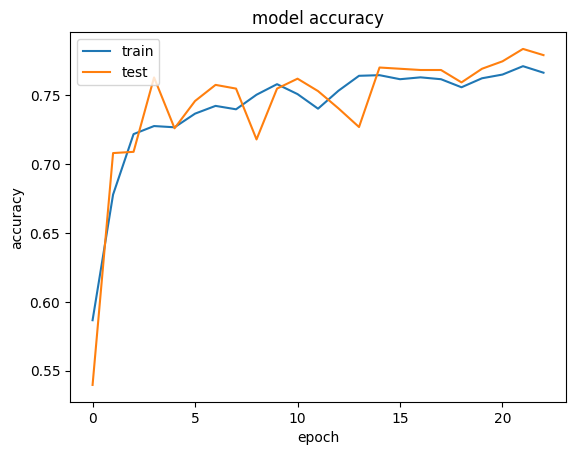

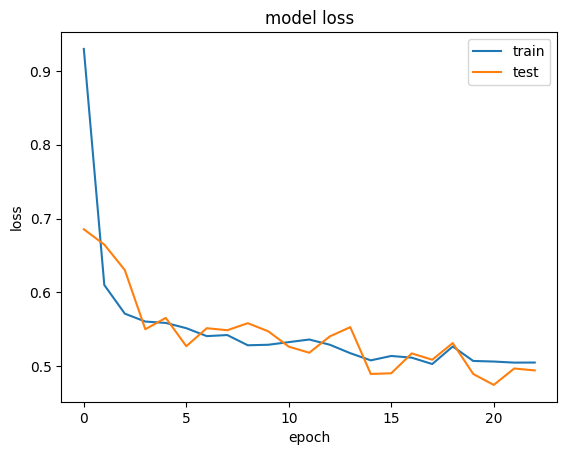

In [ ]:
#plotting its ROC curve
# summarize history for accuracy
plt.plot(opt_history1.history['accuracy'])
plt.plot(opt_history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(opt_history1.history['loss'])
plt.plot(opt_history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### Roc curve

35/35 [==============================] - 0s 3ms/step


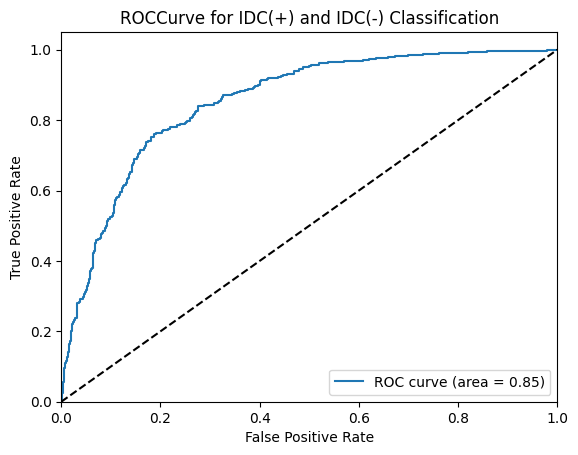

In [ ]:
# Get the predicted probabilities for the test data
CNN_mm_score = cnn_model_opt.predict(X_test)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, CNN_mm_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()


#### optimizing CNN with Standard scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)#stop the iteration if val loss fails to improve after 3 consecutive epochs

seed = 1234
np.random.seed(seed)
SS_history2 = cnn_model_opt.fit(datagen.flow(X_train_scaled_reshaped, Y_train), validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=32, callbacks=[callback])


print(len(SS_history2.history['loss']))#printing the metrics as they iterate over each epoch

Epoch 1/35
139/139 [==============================] - 7s 37ms/step - loss: 1.1025 - accuracy: 0.7138 - val_loss: 0.5925 - val_accuracy: 0.7586
Epoch 2/35
139/139 [==============================] - 6s 42ms/step - loss: 0.5178 - accuracy: 0.7672 - val_loss: 0.5650 - val_accuracy: 0.7811
Epoch 3/35
139/139 [==============================] - 4s 32ms/step - loss: 0.5036 - accuracy: 0.7620 - val_loss: 0.5610 - val_accuracy: 0.7432
Epoch 4/35
139/139 [==============================] - 5s 34ms/step - loss: 0.4935 - accuracy: 0.7683 - val_loss: 0.5403 - val_accuracy: 0.7703
Epoch 5/35
139/139 [==============================] - 5s 39ms/step - loss: 0.4914 - accuracy: 0.7809 - val_loss: 0.5607 - val_accuracy: 0.7775
Epoch 6/35
139/139 [==============================] - 4s 32ms/step - loss: 0.4796 - accuracy: 0.7872 - val_loss: 0.5641 - val_accuracy: 0.7640
Epoch 7/35
139/139 [==============================] - 5s 38ms/step - loss: 0.4815 - accuracy: 0.7836 - val_loss: 0.5260 - val_accuracy: 0.7811

In [ ]:
##Checking the optimized evaluation metrics when using standard scaler
score = cnn_model_opt.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

Y_preds = cnn_model_opt.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       570
           1       0.75      0.85      0.80       540

    accuracy                           0.79      1110
   macro avg       0.80      0.80      0.79      1110
weighted avg       0.80      0.79      0.79      1110



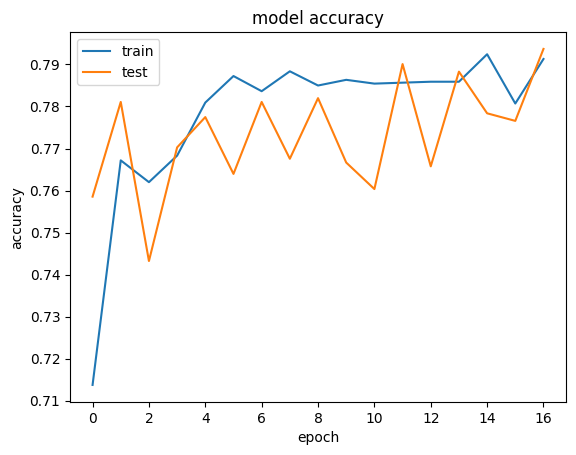

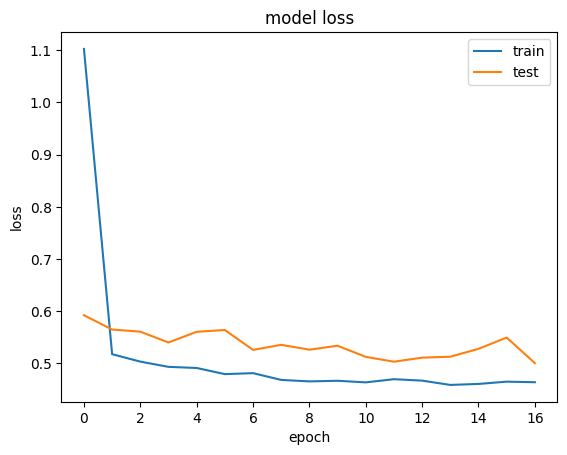

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(SS_history2.history['accuracy'])
plt.plot(SS_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(SS_history2.history['loss'])
plt.plot(SS_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### ROC CURVE

35/35 [==============================] - 0s 3ms/step


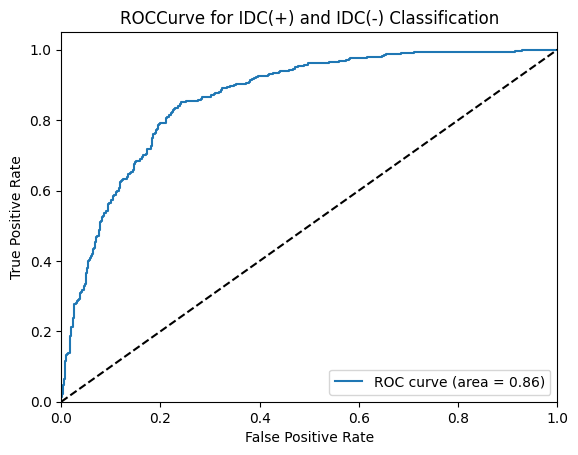

In [ ]:
# Get the predicted probabilities for the test data
CNN_ss_score = cnn_model_opt.predict(X_test_scaled_reshaped)

# Computing the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, CNN_ss_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)#plotting the false and true positive rates
plt.plot([0, 1], [0, 1], 'k--')#inputing a dotted diagonal line
plt.xlim([0.0, 1.0])#setting the x axis limit
plt.ylim([0.0, 1.05])#setting limit for y axis
plt.xlabel('False Positive Rate')# labeling x axis
plt.ylabel('True Positive Rate')#label y axis
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()


## 2. CONVOLUTIONAL RECURRENT NEURAL NETWORK (CRNN)

In [ ]:

# Build the CRNN model
from tensorflow.keras.layers import  Flatten, Dense, LSTM, Reshape
CRNN_model = Sequential()

# Convolutional layers
CRNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
CRNN_model.add(MaxPooling2D(pool_size=(2, 2)))#downsizing features by a factor of 2
CRNN_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CRNN_model.add(MaxPooling2D(pool_size=(2, 2)))#downsizing features by a factor of 2
CRNN_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
CRNN_model.add(MaxPooling2D(pool_size=(2, 2)))#downsizing features by a factor of 2
CRNN_model.add(Flatten())#previous convolutional layers' output is flattened into a 1D vector. It gets the data ready for the next recurrent layer.


# Reshaping the output of convolutional layers to 3D 
CRNN_model.add(Reshape((4, 4*128))) # Adjusting the shape based on the output shape of the previous layer

# Recurrent layer
CRNN_model.add(LSTM(256))#adding a Long Short-Term Memory (LSTM) layer with 256 units

# adding Dense layers
CRNN_model.add(Dense(512, activation='relu'))
CRNN_model.add(Dropout(0.5))#dropping 50% of the neuron during training
CRNN_model.add(Dense(num_classes, activation='sigmoid'))  # Binary classification task

# Compiling the model
epochs = 27 #number of iteration
lr = 0.01 # learning rate
CRNN_model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(CRNN_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 4, 4, 128)      

#### Compiling with Min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5) #stops after 5 consecutive iteration if no loss improvement

seed = 1234
np.random.seed(seed)
CRNN_history1 = CRNN_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])

print(len(CRNN_history1.history['loss']))#printing the metrics as they iterate over each epoch

Epoch 1/27
70/70 [==============================] - 15s 194ms/step - loss: 0.6358 - accuracy: 0.6453 - val_loss: 0.6293 - val_accuracy: 0.6559
Epoch 2/27
70/70 [==============================] - 13s 184ms/step - loss: 0.5863 - accuracy: 0.7011 - val_loss: 0.5551 - val_accuracy: 0.7243
Epoch 3/27
70/70 [==============================] - 12s 178ms/step - loss: 0.5729 - accuracy: 0.7135 - val_loss: 0.5370 - val_accuracy: 0.7405
Epoch 4/27
70/70 [==============================] - 12s 169ms/step - loss: 0.5572 - accuracy: 0.7248 - val_loss: 0.5544 - val_accuracy: 0.7441
Epoch 5/27
70/70 [==============================] - 12s 172ms/step - loss: 0.5411 - accuracy: 0.7422 - val_loss: 0.6058 - val_accuracy: 0.7045
Epoch 6/27
70/70 [==============================] - 13s 185ms/step - loss: 0.5352 - accuracy: 0.7487 - val_loss: 0.5885 - val_accuracy: 0.7018
Epoch 7/27
70/70 [==============================] - 13s 191ms/step - loss: 0.5397 - accuracy: 0.7433 - val_loss: 0.5185 - val_accuracy: 0.7468

In [ ]:
#Checking the evaluation metrics when using min-max scaler
score = CRNN_model.evaluate(X_test, Y_test, verbose=0)

#fetching the predicted values on the test
Y_preds = CRNN_model.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 1s 31ms/step
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       570
           1       0.71      0.79      0.75       540

    accuracy                           0.74      1110
   macro avg       0.74      0.74      0.74      1110
weighted avg       0.74      0.74      0.74      1110



### Compiling with standard scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)#stops after 5 consecutive iteration if no improvement on the loss

seed = 1234
np.random.seed(seed)
#Fitting with the augmented data for better performance
CRNN_history = CRNN_model.fit(X_train_scaled_reshaped, Y_train, validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(CRNN_history.history['loss']))

Epoch 1/27
70/70 [==============================] - 13s 184ms/step - loss: 0.6153 - accuracy: 0.7273 - val_loss: 0.5760 - val_accuracy: 0.7270
Epoch 2/27
70/70 [==============================] - 12s 172ms/step - loss: 0.5161 - accuracy: 0.7521 - val_loss: 0.4963 - val_accuracy: 0.7721
Epoch 3/27
70/70 [==============================] - 12s 175ms/step - loss: 0.4994 - accuracy: 0.7661 - val_loss: 0.4943 - val_accuracy: 0.7694
Epoch 4/27
70/70 [==============================] - 12s 178ms/step - loss: 0.4806 - accuracy: 0.7710 - val_loss: 0.4978 - val_accuracy: 0.7739
Epoch 5/27
70/70 [==============================] - 12s 178ms/step - loss: 0.4687 - accuracy: 0.7742 - val_loss: 0.4974 - val_accuracy: 0.7631
Epoch 6/27
70/70 [==============================] - 13s 188ms/step - loss: 0.4556 - accuracy: 0.7947 - val_loss: 0.4908 - val_accuracy: 0.7928
Epoch 7/27
70/70 [==============================] - 12s 170ms/step - loss: 0.4302 - accuracy: 0.8053 - val_loss: 0.5052 - val_accuracy: 0.7694

In [ ]:
# Evaluating the CRNN_model on the when standard scaler was applied
score = CRNN_model.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

Y_preds = CRNN_model.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)
#printing reports of the prediction during testing
print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 1s 28ms/step
              precision    recall  f1-score   support

           0       0.74      0.71      0.73       570
           1       0.71      0.74      0.72       540

    accuracy                           0.73      1110
   macro avg       0.73      0.73      0.73      1110
weighted avg       0.73      0.73      0.73      1110



### Optimizing the CRNN model

In [ ]:

# Building the CRNN model
from tensorflow.keras.layers import  Flatten, Dense, LSTM, Reshape
CRNN_model_opt = Sequential()

# Convolutional layers
CRNN_model_opt.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))
CRNN_model_opt.add(MaxPooling2D(pool_size=(2, 2)))
CRNN_model_opt.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
CRNN_model_opt.add(MaxPooling2D(pool_size=(2, 2)))
CRNN_model_opt.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
CRNN_model_opt.add(MaxPooling2D(pool_size=(2, 2)))
CRNN_model_opt.add(Flatten())#previous convolutional layers' output is flattened into a 1D vector. It gets the data ready for the next recurrent layer.


# Reshaping the output of convolutional layers to 3D 
CRNN_model_opt.add(Reshape((4, 4*512))) # Adjusting the shape based on the output shape of the previous layer

# inputing the Recurrent layer
CRNN_model_opt.add(LSTM(180))#adds a Long Short-Term Memory (LSTM) layer with 180 units

# inputing the Dense layers
CRNN_model_opt.add(Dense(512, activation='relu'))
CRNN_model_opt.add(Dropout(0.5))
CRNN_model_opt.add(Dense(num_classes, activation='sigmoid'))  # Binary classification task


# Compiling the model
epochs = 25# number of iteration
lr = 0.01 # learning rate
CRNN_model_opt.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(CRNN_model_opt.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 9, 9, 512)         295424    
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 4, 4, 512)      

#### Optimizing the CRNN with min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)#stop iteration if no val loss improvement after 5 consecutive epoch

seed = 1234
np.random.seed(seed)
CRNN_history1 = CRNN_model_opt.fit(datagen.flow(X_train, Y_train), validation_data=(X_test, Y_test), epochs=epochs, batch_size=72, callbacks=[callback])

print(len(CRNN_history1.history['loss']))

Epoch 1/25
139/139 [==============================] - 24s 174ms/step - loss: 0.6056 - accuracy: 0.6822 - val_loss: 0.5399 - val_accuracy: 0.7297
Epoch 2/25
139/139 [==============================] - 22s 162ms/step - loss: 0.5350 - accuracy: 0.7437 - val_loss: 0.5016 - val_accuracy: 0.7685
Epoch 3/25
139/139 [==============================] - 23s 165ms/step - loss: 0.5374 - accuracy: 0.7440 - val_loss: 0.5044 - val_accuracy: 0.7658
Epoch 4/25
139/139 [==============================] - 24s 174ms/step - loss: 0.5333 - accuracy: 0.7494 - val_loss: 0.5073 - val_accuracy: 0.7613
Epoch 5/25
139/139 [==============================] - 24s 172ms/step - loss: 0.5154 - accuracy: 0.7582 - val_loss: 0.5443 - val_accuracy: 0.7360
Epoch 6/25
139/139 [==============================] - 22s 161ms/step - loss: 0.5134 - accuracy: 0.7586 - val_loss: 0.4995 - val_accuracy: 0.7766
Epoch 7/25
139/139 [==============================] - 22s 160ms/step - loss: 0.4992 - accuracy: 0.7618 - val_loss: 0.5069 - val_ac

In [ ]:
#Checking the evaluation metrics when using min-max scaler
score = CRNN_model_opt.evaluate(X_test, Y_test, verbose=0)

Y_preds = CRNN_model_opt.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       570
           1       0.81      0.69      0.75       540

    accuracy                           0.77      1110
   macro avg       0.78      0.77      0.77      1110
weighted avg       0.78      0.77      0.77      1110



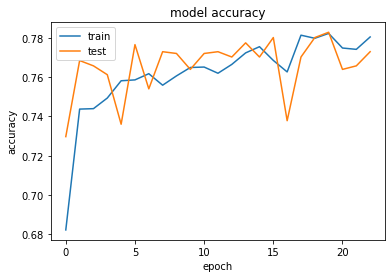

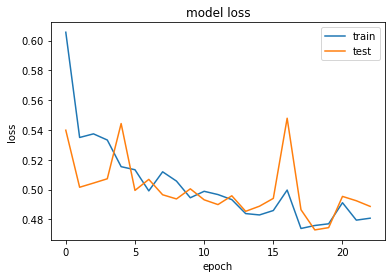

In [ ]:
# summarize history for accuracy
plt.plot(CRNN_history1.history['accuracy'])
plt.plot(CRNN_history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(CRNN_history1.history['loss'])
plt.plot(CRNN_history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

#### ROC curve

35/35 [==============================] - 2s 49ms/step


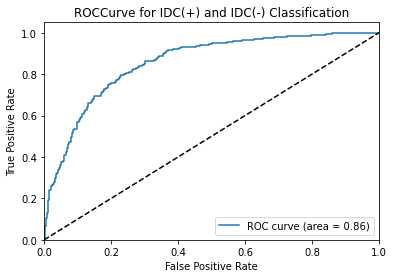

In [ ]:
# Get the predicted probabilities for the test data
CRNN_mm_score = CRNN_model_opt.predict(X_test)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, CRNN_mm_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc) #calculates the false and true positive rate
plt.plot([0, 1], [0, 1], 'k--')#plots a diagonal dash line
plt.xlim([0.0, 1.0])# setting limit for the x axis
plt.ylim([0.0, 1.05])#setting limit for the y axis
plt.xlabel('False Positive Rate')#naming the x axis
plt.ylabel('True Positive Rate')#naming the y axis
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')#tile of the ROC curve
plt.legend(loc="lower right")# where to place the output in the image
plt.show()


#### Optimizing CRNN with standard scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=5)#stops after 5 consecutive epoch if val loss fails to improve

seed = 1234
np.random.seed(seed)
CRNN_history2 = CRNN_model_opt.fit(datagen.flow(X_train_scaled_reshaped, Y_train), validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(CRNN_history2.history['loss']))

Epoch 1/25
139/139 [==============================] - 24s 175ms/step - loss: 0.5438 - accuracy: 0.7379 - val_loss: 0.5128 - val_accuracy: 0.7658
Epoch 2/25
139/139 [==============================] - 24s 175ms/step - loss: 0.5155 - accuracy: 0.7555 - val_loss: 0.4975 - val_accuracy: 0.7748
Epoch 3/25
139/139 [==============================] - 23s 165ms/step - loss: 0.5046 - accuracy: 0.7609 - val_loss: 0.4863 - val_accuracy: 0.7811
Epoch 4/25
139/139 [==============================] - 23s 163ms/step - loss: 0.4853 - accuracy: 0.7703 - val_loss: 0.5401 - val_accuracy: 0.7198
Epoch 5/25
139/139 [==============================] - 26s 190ms/step - loss: 0.4840 - accuracy: 0.7737 - val_loss: 0.4832 - val_accuracy: 0.7928
Epoch 6/25
139/139 [==============================] - 24s 169ms/step - loss: 0.4768 - accuracy: 0.7776 - val_loss: 0.4522 - val_accuracy: 0.7946
Epoch 7/25
139/139 [==============================] - 24s 173ms/step - loss: 0.4732 - accuracy: 0.7879 - val_loss: 0.4942 - val_ac

In [ ]:
##Checking the optimized evaluation metrics when using standard scaler
score = CRNN_model_opt.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

Y_preds = CRNN_model_opt.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 2s 48ms/step
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       570
           1       0.77      0.83      0.80       540

    accuracy                           0.80      1110
   macro avg       0.80      0.80      0.80      1110
weighted avg       0.80      0.80      0.80      1110



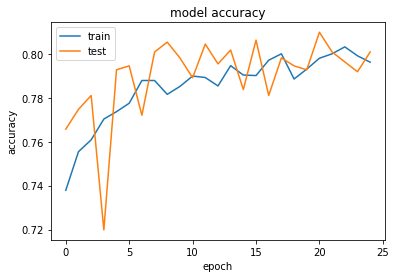

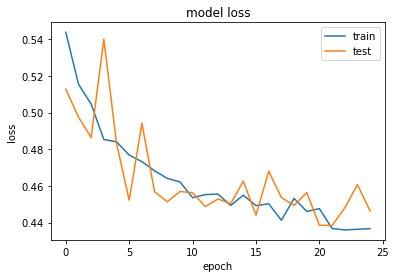

In [ ]:
# summarize history for accuracy
plt.plot(CRNN_history2.history['accuracy'])
plt.plot(CRNN_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(CRNN_history2.history['loss'])
plt.plot(CRNN_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

35/35 [==============================] - 2s 49ms/step


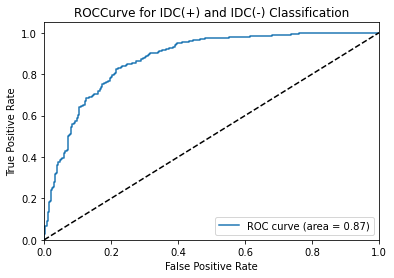

In [ ]:
# Get the predicted probabilities for the test data
CRNN_ss_score = CRNN_model_opt.predict(X_test_scaled_reshaped)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, CRNN_ss_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()


# MULTILAYER PERCEPTRON (MLP)

In [ ]:
# Create the MLP model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(50, 50, 3)))# This layer flattens the output to 1D to suit the dense layer
mlp_model.add(Dense(32, activation='relu'))#add a dense layer with 32 neurons
mlp_model.add(Dense(64, activation='relu'))#add a dense layer with 64 neurons
mlp_model.add(Dense(128, activation='relu'))#add a dense layer with 128 neurons
mlp_model.add(Dense(320, activation='relu'))#add a dense layer with 320 neurons
mlp_model.add(Dense(num_classes, activation='sigmoid')) # "sigmoid" due to Binary classification represents 

# Compiling the model
epochs = 35 #will run for 35 epoch as long as val loss does'nt fail to improve in number of set patience consecutively
lr = 0.001 # learning rate
mlp_model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['accuracy'])#binary cross_entropy is ideal for binary classification task
print(mlp_model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 7500)              0         
                                                                 
 dense_53 (Dense)            (None, 32)                240032    
                                                                 
 dense_54 (Dense)            (None, 64)                2112      
                                                                 
 dense_55 (Dense)            (None, 128)               8320      
                                                                 
 dense_56 (Dense)            (None, 320)               41280     
                                                                 
 dense_57 (Dense)            (None, 1)                 321       
                                                                 
Total params: 292,065
Trainable params: 292,065
Non-t

### compiling with min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
mlp_history1 = mlp_model.fit(datagen.flow(X_train, Y_train), validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(mlp_history1.history['loss']))

Epoch 1/35
139/139 [==============================] - 5s 31ms/step - loss: 0.6876 - accuracy: 0.5632 - val_loss: 0.6296 - val_accuracy: 0.6829
Epoch 2/35
139/139 [==============================] - 4s 29ms/step - loss: 0.6432 - accuracy: 0.6419 - val_loss: 0.6482 - val_accuracy: 0.6369
Epoch 3/35
139/139 [==============================] - 4s 29ms/step - loss: 0.6434 - accuracy: 0.6293 - val_loss: 0.6353 - val_accuracy: 0.7063
Epoch 4/35
139/139 [==============================] - 4s 29ms/step - loss: 0.6283 - accuracy: 0.6615 - val_loss: 0.6261 - val_accuracy: 0.6847
Epoch 5/35
139/139 [==============================] - 4s 29ms/step - loss: 0.6028 - accuracy: 0.6842 - val_loss: 0.5602 - val_accuracy: 0.7117
Epoch 6/35
139/139 [==============================] - 4s 32ms/step - loss: 0.5886 - accuracy: 0.6984 - val_loss: 0.6371 - val_accuracy: 0.6387
Epoch 7/35
139/139 [==============================] - 4s 29ms/step - loss: 0.5968 - accuracy: 0.6939 - val_loss: 0.7022 - val_accuracy: 0.4946

In [ ]:
#Checking the evaluation metrics when using min-max scaler
score = mlp_model.evaluate(X_test, Y_test, verbose=0)

Y_preds = mlp_model.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       570
           1       0.72      0.81      0.77       540

    accuracy                           0.76      1110
   macro avg       0.76      0.76      0.76      1110
weighted avg       0.76      0.76      0.76      1110



### compiling with standard scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
mlp_history2 = mlp_model.fit(datagen.flow(X_train_scaled_reshaped, Y_train), validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(mlp_history2.history['loss']))

Epoch 1/25
70/70 [==============================] - 0s 6ms/step - loss: 1.6180 - accuracy: 0.7924 - val_loss: 0.9477 - val_accuracy: 0.6712
Epoch 2/25
70/70 [==============================] - 0s 5ms/step - loss: 0.2500 - accuracy: 0.9126 - val_loss: 0.8655 - val_accuracy: 0.7486
Epoch 3/25
70/70 [==============================] - 0s 5ms/step - loss: 0.1273 - accuracy: 0.9583 - val_loss: 0.9834 - val_accuracy: 0.7009
Epoch 4/25
70/70 [==============================] - 0s 5ms/step - loss: 0.1612 - accuracy: 0.9603 - val_loss: 1.1074 - val_accuracy: 0.6811
Epoch 5/25
70/70 [==============================] - 0s 5ms/step - loss: 0.0399 - accuracy: 0.9896 - val_loss: 1.1577 - val_accuracy: 0.7081
Epoch 6/25
70/70 [==============================] - 0s 5ms/step - loss: 0.0394 - accuracy: 0.9896 - val_loss: 1.2157 - val_accuracy: 0.7360
Epoch 7/25
70/70 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9971 - val_loss: 1.2729 - val_accuracy: 0.7225
Epoch 8/25
70/70 [==

In [ ]:
##Checking the optimized evaluation metrics when using standard scaler
score = mlp_model.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

Y_preds = mlp_model.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.53      0.95      0.68       570
           1       0.67      0.11      0.19       540

    accuracy                           0.54      1110
   macro avg       0.60      0.53      0.43      1110
weighted avg       0.60      0.54      0.44      1110



### Optimizing the MLP model

In [ ]:
from keras.layers import Dropout

mlp_model_opt = Sequential()
mlp_model_opt.add(Flatten(input_shape=(50, 50, 3)))
mlp_model_opt.add(Dense(32, activation='relu'))
mlp_model_opt.add(Dense(64, activation='relu'))
mlp_model_opt.add(Dense(128, activation='relu'))
#mlp_model_opt.add(Dense(320, activation='relu'))
mlp_model_opt.add(Dense(128, activation='relu'))
mlp_model_opt.add(Dense(320, activation='relu'))
mlp_model_opt.add(Dropout(0.2))
mlp_model_opt.add(Dense(num_classes, activation='sigmoid'))

# Compile the model
epochs = 25
lr = 0.01
mlp_model_opt.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(mlp_model_opt.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 7500)              0         
                                                                 
 dense_33 (Dense)            (None, 32)                240032    
                                                                 
 dense_34 (Dense)            (None, 64)                2112      
                                                                 
 dense_35 (Dense)            (None, 128)               8320      
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                                 
 dense_37 (Dense)            (None, 320)               41280     
                                                                 
 dropout_20 (Dropout)        (None, 320)              

### optimizing MLP with min-max scaler

In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
mlp_opt_history1 = mlp_model_opt.fit(datagen.flow(X_train, Y_train), validation_data=(X_test, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(mlp_opt_history1.history['loss']))

Epoch 1/25
139/139 [==============================] - 5s 31ms/step - loss: 0.6896 - accuracy: 0.5382 - val_loss: 0.6261 - val_accuracy: 0.6514
Epoch 2/25
139/139 [==============================] - 4s 29ms/step - loss: 0.6374 - accuracy: 0.6441 - val_loss: 0.6047 - val_accuracy: 0.7000
Epoch 3/25
139/139 [==============================] - 4s 29ms/step - loss: 0.6199 - accuracy: 0.6685 - val_loss: 0.5696 - val_accuracy: 0.7144
Epoch 4/25
139/139 [==============================] - 4s 29ms/step - loss: 0.6062 - accuracy: 0.6797 - val_loss: 0.6086 - val_accuracy: 0.7054
Epoch 5/25
139/139 [==============================] - 4s 30ms/step - loss: 0.5915 - accuracy: 0.6926 - val_loss: 0.5729 - val_accuracy: 0.7532
Epoch 6/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5887 - accuracy: 0.7027 - val_loss: 0.6059 - val_accuracy: 0.6721
Epoch 7/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5868 - accuracy: 0.6915 - val_loss: 0.5348 - val_accuracy: 0.7523

In [ ]:
#CHECKING THE EVALUATION
score = mlp_model_opt.evaluate(X_test, Y_test, verbose=0)

Y_preds = mlp_model_opt.predict(X_test)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       570
           1       0.72      0.81      0.76       540

    accuracy                           0.75      1110
   macro avg       0.76      0.75      0.75      1110
weighted avg       0.76      0.75      0.75      1110



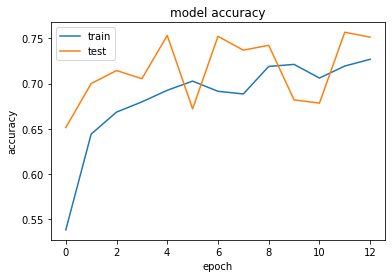

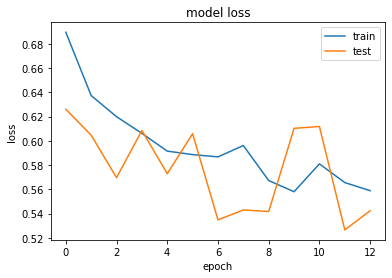

In [ ]:
#plotting its ROC curve
# summarize history for accuracy
plt.plot(mlp_opt_history1.history['accuracy'])
plt.plot(mlp_opt_history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mlp_opt_history1.history['loss'])
plt.plot(mlp_opt_history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### ROC curve

35/35 [==============================] - 0s 2ms/step


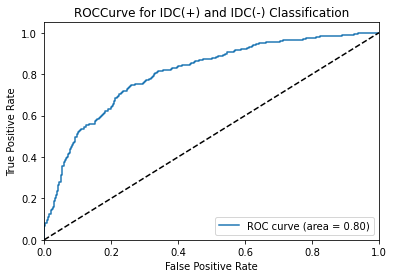

In [ ]:
# Get the predicted probabilities for the test data
MLP_mm_score = mlp_model_opt.predict(X_test)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, MLP_mm_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()


### optimizing MLP with standard scaler







In [ ]:
callback = EarlyStopping(monitor='loss', patience=3)

seed = 1234
np.random.seed(seed)
mlp_opt_history2 = mlp_model_opt.fit(datagen.flow(X_train_scaled_reshaped, Y_train), validation_data=(X_test_scaled_reshaped, Y_test), epochs=epochs, batch_size=64, callbacks=[callback])


print(len(mlp_opt_history2.history['loss']))

Epoch 1/25
139/139 [==============================] - 4s 31ms/step - loss: 0.7702 - accuracy: 0.7226 - val_loss: 0.5095 - val_accuracy: 0.7640
Epoch 2/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5206 - accuracy: 0.7564 - val_loss: 0.5000 - val_accuracy: 0.7739
Epoch 3/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5175 - accuracy: 0.7625 - val_loss: 0.4902 - val_accuracy: 0.7721
Epoch 4/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5106 - accuracy: 0.7670 - val_loss: 0.4926 - val_accuracy: 0.7694
Epoch 5/25
139/139 [==============================] - 4s 29ms/step - loss: 0.5065 - accuracy: 0.7672 - val_loss: 0.4869 - val_accuracy: 0.7694
Epoch 6/25
139/139 [==============================] - 4s 30ms/step - loss: 0.5022 - accuracy: 0.7688 - val_loss: 0.4889 - val_accuracy: 0.7730
Epoch 7/25
139/139 [==============================] - 4s 30ms/step - loss: 0.5047 - accuracy: 0.7649 - val_loss: 0.4831 - val_accuracy: 0.7775

In [ ]:
#CHECKING THE EVALUATION
score = mlp_model_opt.evaluate(X_test_scaled_reshaped, Y_test, verbose=0)

Y_preds = mlp_model_opt.predict(X_test_scaled_reshaped)
Y_preds = np.round(Y_preds).astype(int)

print(classification_report(Y_test, Y_preds))
conf_matx = confusion_matrix(Y_test, Y_preds)

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       570
           1       0.73      0.86      0.79       540

    accuracy                           0.78      1110
   macro avg       0.79      0.78      0.78      1110
weighted avg       0.79      0.78      0.78      1110



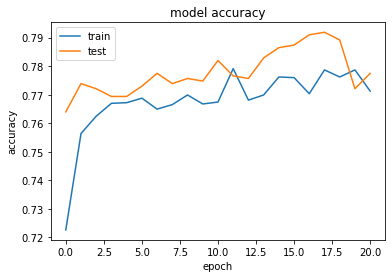

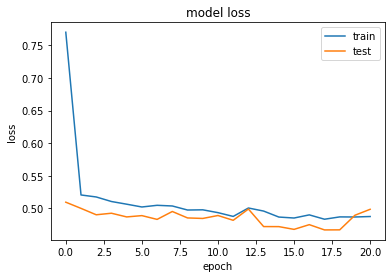

In [ ]:
#plotting its ROC curve
# summarize history for accuracy
plt.plot(mlp_opt_history2.history['accuracy'])
plt.plot(mlp_opt_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mlp_opt_history2.history['loss'])
plt.plot(mlp_opt_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### ROC curve and AUC

35/35 [==============================] - 0s 2ms/step


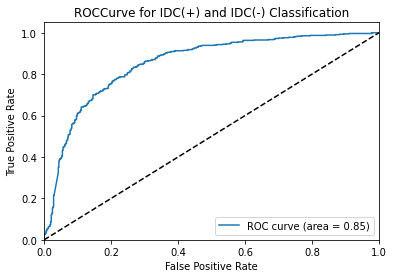

In [ ]:
# Get the predicted probabilities for the test data
MLP_ss_score = mlp_model_opt.predict(X_test_scaled_reshaped)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, MLP_ss_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()


## PRE-TRAINED MODEL (ResNet50)

In [18]:
# Resizing the images in x_train to suit the pre-trained model
resized_X_train = []
for image in X_train:
    resized_image = resize(image, (125, 200, 3), mode='constant')
    resized_X_train.append(resized_image)

# Converting resized_x_train to numpy array
resized_X_train = np.array(resized_X_train)

# Reshaping the images in x_test
resized_X_test = []
for image in X_test:
    resized_image = resize(image, (125, 200, 3), mode='constant')
    resized_X_test.append(resized_image)

# Converting the resized_x_test to numpy array
resized_X_test = np.array(resized_X_test)

# Verifying the new shapes
print(resized_X_train.shape)
print(resized_X_test.shape)


(4437, 125, 200, 3)
(1110, 125, 200, 3)


In [19]:
# Define the input shape
input_shape = (125, 200, 3)

# Loading the pre-trained ResNet50 model (excluding the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Creating a new model based on ResNet50
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(Conv2D(hp.Int('filter_size', min_value=16, max_value=128, step=1), kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    # Defining the learning rates and filter sizes
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.002, 0.0002])
    filter_size = hp.Choice('filter_size', values=[16, 32, 64])


    # Compiling the model with the specified learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model


94765736/94765736 [==============================] - 7s 0us/step


In [20]:
# Defining the hyperparameters search space
hp = HyperParameters()
hp.Choice('filter_size', values=[16, 32, 64])
hp.Choice('learning_rate', values=[0.01, 0.002, 0.0002])


0.01

In [21]:
# Defineing the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='resnet_tuner'
)


In [22]:
# Performing the hyperparameter search
tuner.search(resized_X_train, Y_train, epochs=5, validation_data=(resized_X_test, Y_test))

# Getting the best hyperparameters for training
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 5 Complete [00h 03m 40s]
val_loss: 0.509303629398346

Best val_loss So Far: 0.47509753704071045
Total elapsed time: 00h 18m 21s


In [23]:
 #Building the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [24]:
# Train the model
pretrained_history = model.fit(datagen.flow(resized_X_train, Y_train), epochs=25, validation_data=(resized_X_test, Y_test))

Epoch 1/25
139/139 [==============================] - 82s 281ms/step - loss: 0.7746 - accuracy: 0.6766 - val_loss: 0.6957 - val_accuracy: 0.7423
Epoch 2/25
139/139 [==============================] - 37s 268ms/step - loss: 0.5852 - accuracy: 0.7259 - val_loss: 0.5591 - val_accuracy: 0.7568
Epoch 3/25
139/139 [==============================] - 37s 268ms/step - loss: 0.5508 - accuracy: 0.7372 - val_loss: 0.5229 - val_accuracy: 0.7649
Epoch 4/25
139/139 [==============================] - 36s 255ms/step - loss: 0.5406 - accuracy: 0.7440 - val_loss: 0.5343 - val_accuracy: 0.7514
Epoch 5/25
139/139 [==============================] - 36s 261ms/step - loss: 0.5357 - accuracy: 0.7501 - val_loss: 0.5151 - val_accuracy: 0.7658
Epoch 6/25
139/139 [==============================] - 38s 270ms/step - loss: 0.5345 - accuracy: 0.7460 - val_loss: 0.5143 - val_accuracy: 0.7712
Epoch 7/25
139/139 [==============================] - 36s 255ms/step - loss: 0.5314 - accuracy: 0.7474 - val_loss: 0.5152 - val_ac

In [25]:
# Evaluating the model
model.evaluate(resized_X_test, Y_test)
loss, accuracy = model.evaluate(resized_X_test, Y_test)
print("Testing Metrics:")
print("Loss:", loss)
print("Accuracy:", accuracy)

35/35 [==============================] - 2s 58ms/step - loss: 0.4681 - accuracy: 0.7964
Testing Metrics:
Loss: 0.4680672883987427
Accuracy: 0.7963963747024536


In [26]:

# Predict on the test set
Y_pred = model.predict(resized_X_test)
Y_pred = (Y_pred > 0.5).astype(int)#any predicted probability above 0.5 is considered as a positive prediction, any probability below 0.5 is a negative prediction.

# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

35/35 [==============================] - 3s 56ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       570
           1       0.76      0.85      0.80       540

    accuracy                           0.80      1110
   macro avg       0.80      0.80      0.80      1110
weighted avg       0.80      0.80      0.80      1110



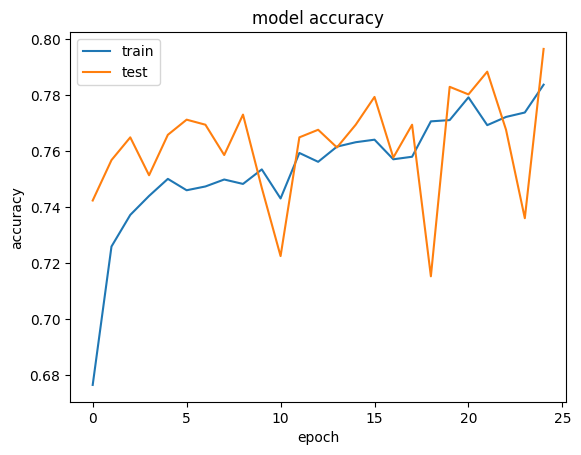

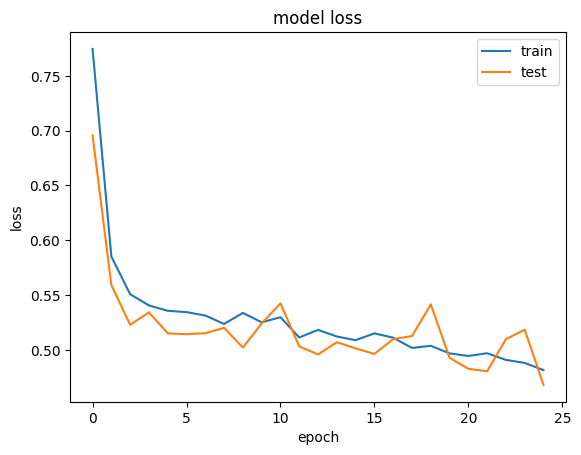

In [27]:
# summarize history for accuracy
plt.plot(pretrained_history.history['accuracy'])
plt.plot(pretrained_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(pretrained_history.history['loss'])
plt.plot(pretrained_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Optimizing ResNet Using standard scaler 

In [ ]:
# Resizing the images in x_train to suit the pre-trained model
resized_X_train2 = []
for image in X_train_scaled_reshaped:
    resized_image = resize(image, (125, 200, 3), mode='constant')
    resized_X_train2.append(resized_image)

# Converting resized_x_train to numpy array
resized_X_train2 = np.array(resized_X_train2)

# Reshaping the images in x_test
resized_X_test2 = []
for image in X_test_scaled_reshaped:
    resized_image2 = resize(image, (125, 200, 3), mode='constant')
    resized_X_test2.append(resized_image2)

# Converting the resized_x_test to numpy array
resized_X_test2 = np.array(resized_X_test2)

# Verifying the new shapes
print(resized_X_train2.shape)
print(resized_X_test2.shape)


(4437, 125, 200, 3)
(1110, 125, 200, 3)


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define the input shape
input_shape = (125, 200, 3)

# Load the pre-trained ResNet50 model (excluding the top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new model based on ResNet50
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    # Defining the learning rate hyperparameter
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])

    # Compiling the model with the specified learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model



In [ ]:
# Defining the hyperparameters search space
hp = HyperParameters()
hp.Choice('filter_size', values=[32, 64, 128])
hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


0.01

In [ ]:
# Defineing the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='resnet_tuner'
)

In [ ]:
# Performing the hyperparameter search with the standard scaler train & test data
tuner.search(resized_X_train2, Y_train, epochs=5, validation_data=(resized_X_test2, Y_test))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
 #Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [ ]:
# Train the model
pretrained_history2 = model.fit(datagen.flow(resized_X_train2, Y_train), epochs=25, validation_data=(resized_X_test2, Y_test))

Epoch 1/25
139/139 [==============================] - 76s 265ms/step - loss: 0.5083 - accuracy: 0.7566 - val_loss: 0.8650 - val_accuracy: 0.5135
Epoch 2/25
139/139 [==============================] - 35s 249ms/step - loss: 0.4309 - accuracy: 0.8071 - val_loss: 1.0418 - val_accuracy: 0.5135
Epoch 3/25
139/139 [==============================] - 36s 260ms/step - loss: 0.3983 - accuracy: 0.8253 - val_loss: 0.7959 - val_accuracy: 0.5135
Epoch 4/25
139/139 [==============================] - 36s 257ms/step - loss: 0.3841 - accuracy: 0.8296 - val_loss: 0.7748 - val_accuracy: 0.5369
Epoch 5/25
139/139 [==============================] - 35s 254ms/step - loss: 0.3469 - accuracy: 0.8503 - val_loss: 0.7996 - val_accuracy: 0.6153
Epoch 6/25
139/139 [==============================] - 35s 248ms/step - loss: 0.3298 - accuracy: 0.8639 - val_loss: 0.4407 - val_accuracy: 0.8126
Epoch 7/25
139/139 [==============================] - 36s 255ms/step - loss: 0.3063 - accuracy: 0.8679 - val_loss: 0.4384 - val_ac

In [ ]:
# Evaluate the model
model.evaluate(resized_X_test2, Y_test)
loss, accuracy = model.evaluate(resized_X_test2, Y_test)
print("Testing Metrics:")
print("Loss:", loss)
print("Accuracy:", accuracy)

35/35 [==============================] - 2s 55ms/step - loss: 0.6036 - accuracy: 0.8234
Testing Metrics:
Loss: 0.6036494970321655
Accuracy: 0.823423445224762


In [ ]:

# Predict on the test set
Y_pred = model.predict(resized_X_test2)
Y_pred = (Y_pred > 0.5).astype(int)#any predicted probability above 0.5 is considered as a positive prediction, any probability below 0.5 is a negative prediction.

# Classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred))

35/35 [==============================] - 3s 53ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.81       570
           1       0.78      0.89      0.83       540

    accuracy                           0.82      1110
   macro avg       0.83      0.83      0.82      1110
weighted avg       0.83      0.82      0.82      1110



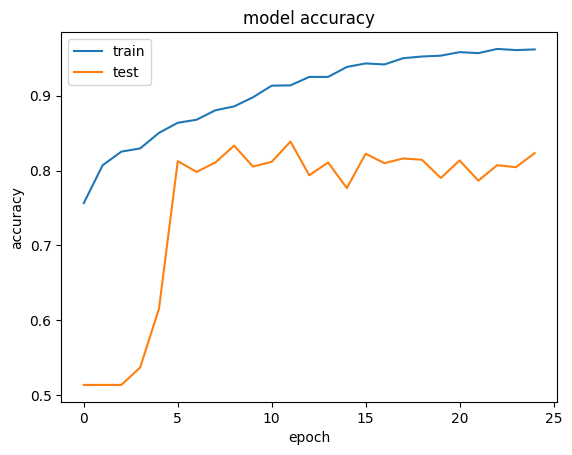

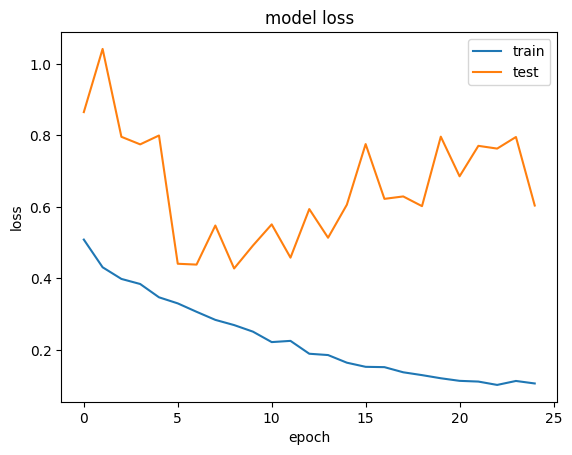

In [ ]:
# summarize history for accuracy
plt.plot(pretrained_history2.history['accuracy'])
plt.plot(pretrained_history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(pretrained_history2.history['loss'])
plt.plot(pretrained_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### ROC curve

35/35 [==============================] - 2s 55ms/step


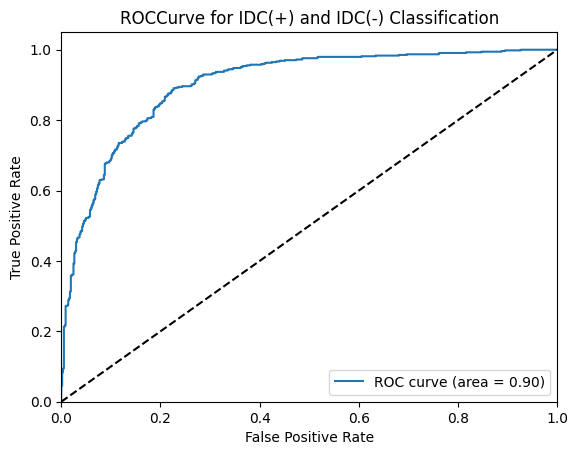

In [ ]:
# Get the predicted probabilities for the test data
ResNet_ss_score = model.predict(resized_X_test2)

# Compute the ROC curve and AUC for the positive class
fpr, tpr, _ = roc_curve(Y_test, ResNet_ss_score)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCCurve for IDC(+) and IDC(-) Classification')
plt.legend(loc="lower right")
plt.show()

#### HISTOGRAM PLOT OF VAL LOSS, VAL ACCURACY, F1 SCORE AND ROC AFTER FINE-TUNING IN ALL MODELS

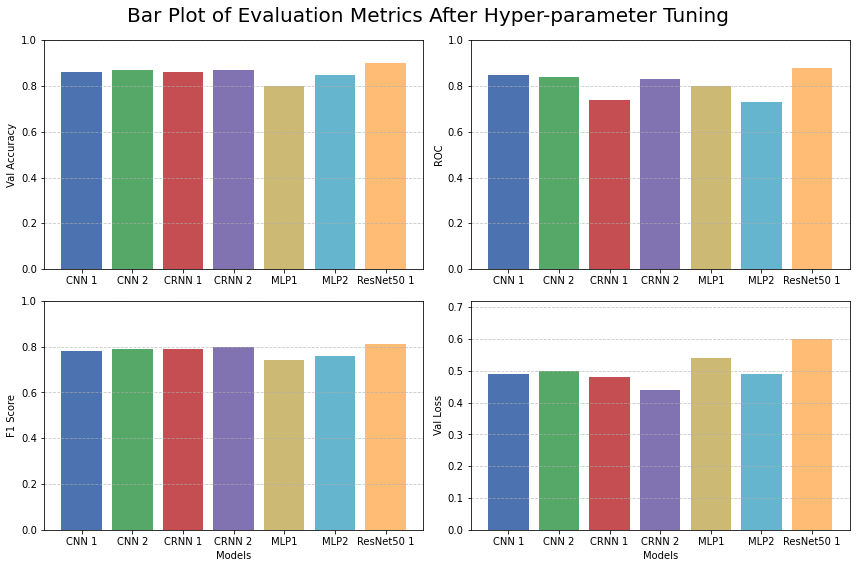

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Defining the evaluation metrics
models = ['CNN 1', 'CNN 2', 'CRNN 1', 'CRNN 2', 'MLP1', 'MLP2', 'ResNet50 1']
accuracy = [0.76, 0.79, 0.78, 0.79, 0.72, 0.77, 0.96]
recall = [0.78, 0.74, 0.85, 0.77, 0.69, 0.70, 0.76]
f1_score = [0.78, 0.79, 0.79, 0.80, 0.74, 0.76, 0.81]
precision = [0.79, 0.80, 0.75, 0.80, 0.76, 0.79, 0.83]
roc = [0.85, 0.84, 0.74, 0.83, 0.80, 0.73, 0.88]
val_accuracy = [0.86, 0.87, 0.86, 0.87, 0.80, 0.85, 0.90]
val_loss = [0.49, 0.50, 0.48, 0.44, 0.54, 0.49, 0.60]

# Setting up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Bar Plot of Evaluation Metrics After Hyper-parameter Tuning', fontsize=20)

# Setting a custom color palette
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd', '#ffbc75']

# Plotting Val Accuracy
axs[0, 0].bar(models, val_accuracy, color=colors)
axs[0, 0].set_ylabel('Val Accuracy')
axs[0, 0].set_ylim([0, 1])

# Plotting ROC curve
axs[0, 1].bar(models, roc, color=colors)
axs[0, 1].set_ylabel('ROC')
axs[0, 1].set_ylim([0, 1])

# Plotting F1 Score
axs[1, 0].bar(models, f1_score, color=colors)
axs[1, 0].set_xlabel('Models')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 0].set_ylim([0, 1])

# Plotting Validation Loss
axs[1, 1].bar(models, val_loss, color=colors)
axs[1, 1].set_xlabel('Models')
axs[1, 1].set_ylabel('Val Loss')
axs[1, 1].set_ylim([0, max(val_loss) * 1.2])

# Adjusting the layout and add gridlines
plt.tight_layout()
for ax in axs.flatten():
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
